# Time Series Course (part 1)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
lynx_df = pd.read_csv('lynx_data.csv')
lynx_df.head()

,year,trappings
0,1821,269
1,1822,321
2,1823,585
3,1824,871
4,1825,1475


Text(0, 0.5, '# Trappings')

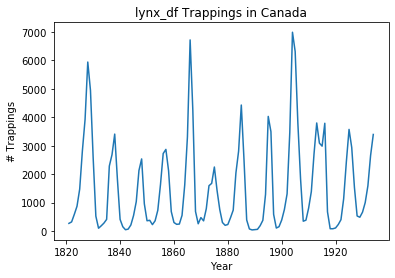

In [13]:
plt.plot(lynx_df['year'], lynx_df['trappings'])
plt.title("lynx_df Trappings in Canada")
plt.xlabel("Year")
plt.ylabel("# Trappings")

seasonal pulses: peaks at every few years <br>
Autocorrelation: previous trapped lynx_df is an indicator of future population

#### Generate time series

In [17]:
lynx_ts = lynx_df['trappings']
print(type(lynx_ts))
lynx_ts.head()

<class 'pandas.core.series.Series'>


0     269
1     321
2     585
3     871
4    1475
Name: trappings, dtype: int64

In [23]:
lynx_ts = pd.Series(lynx_df['trappings'].values, index=pd.date_range('1821', periods=114, freq='Y'))
print(type(lynx_ts))
lynx_ts.head()

<class 'pandas.core.series.Series'>


1821-12-31     269
1822-12-31     321
1823-12-31     585
1824-12-31     871
1825-12-31    1475
Freq: A-DEC, dtype: int64

In [25]:
lynx_ts = pd.Series(lynx_df['trappings'].values, index=pd.DatetimeIndex(data = (tuple(pd.date_range('1821', periods=114, freq='Y'))), freq='Y'))
print(type(lynx_ts))
lynx_ts.head()

<class 'pandas.core.series.Series'>


1821-12-31     269
1822-12-31     321
1823-12-31     585
1824-12-31     871
1825-12-31    1475
Freq: A-DEC, dtype: int64

### Statistical characteristics of time series data
- trend - pattern
- seasonality - trend that repeats over and over
- mean - mu
- variance - sigma
- autocorrelation
- stationarity

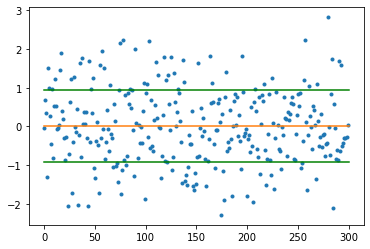

In [44]:
np.random.seed(37)
arr = np.random.randn(300)
mu = np.mean(arr)
sigma = np.var(arr)
plt.plot(arr, '.')
plt.plot([0,len(arr)], [mu, mu])
plt.plot([0,len(arr)], [sigma, sigma], 'g')
plt.plot([0,len(arr)], [-sigma, -sigma], 'g')

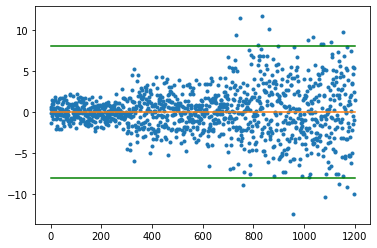

In [45]:
mu2 = 0
mu3 = 0
sigma2 = 2
sigma3 = 4
arr2 = np.random.randn(400)*sigma2 + mu2
arr3 = np.random.randn(500)*sigma3 + mu3
arrx = np.hstack([arr, arr2, arr3])
mux = np.mean(arrx)
sigmax = np.var(arrx)
plt.plot(arrx, '.')
plt.plot([0,len(arrx)], [mux, mux])
plt.plot([0,len(arrx)], [sigmax, sigmax], 'g')
plt.plot([0,len(arrx)], [-sigmax, -sigmax], 'g')

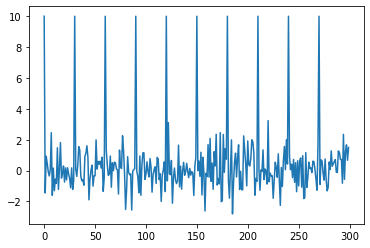

In [46]:
arrn = np.random.randn(300)
for i in range(len(arrn)):
    if i%30 == 0:
        arrn[i] = 10
        
plt.plot(arrn)

This shows seasonality